# NeuroKin: Motor-Visual Decoder for Robot Self-Modeling

## Overview

This notebook implements a neural network that learns to generate robot visual representations directly from joint angle inputs. The core idea is to train a model that takes motor commands (4 joint angles) and outputs a visual image of the robot in that pose. This is different from typical computer vision tasks where we try to estimate angles from images. Instead, we go in the reverse direction: can we predict what the robot looks like based on its joint configuration?

This type of model is useful for robot self-modeling because it helps the robot learn its own body structure. By training on paired data from simulation, the network learns a compact representation of the robot's kinematics and visual appearance.

## Approach

The network uses an encoder-decoder architecture where the motor information (4 joint angles) is first compressed into a latent representation, then expanded back into a 100×100 binary image showing the robot's silhouette. This forces the network to learn meaningful features about how different joint configurations map to different visual appearances.

## Environment Setup

In [1]:
!pip install -q gdown pybullet tqdm matplotlib torch

import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
Device: cuda
GPU: Tesla T4
CUDA Version: 12.6
GPU Memory: 15.83 GB


## Data Preparation

The data comes from PyBullet simulation where we generated synthetic images of a 4-DOF robot arm in various poses. Each training sample consists of a pair: the joint angles of the robot and a corresponding binary image showing the robot's silhouette.

We download the simulated dataset and the robot URDF file from Google Drive, then perform several preprocessing steps to ensure the data is in the right format. The angles need to be in the correct shape (we drop the first two DOFs if they exist, keeping only the four actuated joints), and the images need to be normalized to the range [0, 1] and converted to single-channel grayscale if necessary.

The dataset is split into training and testing sets with an 80/20 split. This split allows us to monitor how well the model generalizes to unseen poses. The training set teaches the model the relationship between angles and images, while the test set helps us evaluate if it has really learned this relationship or just memorized the training data.

In [2]:
import gdown

os.makedirs('data', exist_ok=True)
os.makedirs('RobotArmURDF/4dof_1st/urdf', exist_ok=True)

data_url = 'https://drive.google.com/uc?id=1TVzU_-xblSQ7QM30MHXWNOt2Rl3hmpr3'
data_path = 'data/sim_data_robo1_lorenz_colab_2000.npz'

if not os.path.exists(data_path):
    print("Downloading dataset...")
    gdown.download(data_url, data_path, quiet=False)

urdf_url = 'https://drive.google.com/uc?id=1bBogWAaYzGWMJJQUHD10b45o_0asLS21'
urdf_path = 'RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf'

if not os.path.exists(urdf_path):
    print("Downloading URDF...")
    gdown.download(urdf_url, urdf_path, quiet=False)

print("Files ready")

Downloading...
From: https://drive.google.com/uc?id=1TVzU_-xblSQ7QM30MHXWNOt2Rl3hmpr3
To: /content/data/sim_data_robo1_lorenz_colab_2000.npz
100%|██████████| 20.3M/20.3M [00:00<00:00, 72.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=1bBogWAaYzGWMJJQUHD10b45o_0asLS21
To: /content/RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf
100%|██████████| 6.12k/6.12k [00:00<00:00, 19.3MB/s]

Files ready


In [3]:
data = np.load(data_path)
images = data['images']
angles = data['angles']
focal_length = float(data['focal'])

if angles.shape[1] == 6:
    angles = angles[:, 2:]

if images.max() > 1.0:
    images = images.astype(np.float32) / 255.0

if images.ndim == 4 and images.shape[-1] == 3:
    images = np.mean(images, axis=-1)
if images.ndim == 3:
    images = images[..., None]

train_ratio = 0.8
split_idx = int(len(images) * train_ratio)

train_images = torch.from_numpy(images[:split_idx]).float()
train_angles = torch.from_numpy(angles[:split_idx]).float()
test_images = torch.from_numpy(images[split_idx:]).float()
test_angles = torch.from_numpy(angles[split_idx:]).float()

print(f"Dataset loaded and split:")
print(f"  Training: {len(train_images)} samples")
print(f"  Testing: {len(test_images)} samples")
print(f"  Image size: {images[0].shape}")
print(f"  Joint DOF: {angles.shape[1]}")

Dataset loaded and split:
  Training: 1600 samples
  Testing: 400 samples
  Image size: (100, 100, 1)
  Joint DOF: 4


## Architecture Design

The NeuroKineticDecoder is designed with three main components that work together to transform motor input into visual output.

**The Encoder** takes the four joint angles as input and processes them through three fully connected layers with ReLU activation functions. This part of the network learns to extract important features from the motor information and compress them into a 1024-dimensional latent vector. This latent vector acts as a bottleneck that forces the network to learn a compact representation of the joint configuration.

**The Spatial Expansion** layer takes the latent vector and expands it into a 4D spatial feature map with shape (256, 4, 4). This transition from abstract motor information to spatial features is crucial because images are inherently spatial, and we need to eventually produce a 100×100 output image. The expansion is done through a fully connected layer followed by reshaping.

**The Decoder** uses convolutional transpose (deconvolution) layers to gradually expand the spatial features into the full 100×100 image. Each deconvolution layer is followed by batch normalization, which helps stabilize training by normalizing the activations. The progressive expansion through different feature scales (256 → 128 → 64 → 32 → 16) allows the network to learn features at different levels of detail.

The final output head uses two regular convolution layers and a sigmoid activation to produce the final binary mask. The sigmoid activation squashes the output to the range [0, 1], which is appropriate for predicting a binary image where each pixel is either background (0) or robot (1).

The choice of 1024 latent dimensions is a balance between having enough capacity to capture the complexity of the robot's appearance and not being so large that the model becomes hard to train or overfits. With only 4 input values, a small latent dimension might lose important information, but a very large one would be wasteful.

In [4]:
class NeuroKineticDecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        
        self.latent_to_spatial = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.output_head = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, angles):
        latent = self.encoder(angles)
        spatial = self.latent_to_spatial(latent)
        spatial = spatial.view(-1, 256, 4, 4)
        features = self.decoder(spatial)
        
        if features.shape[2:] != (100, 100):
            features = F.interpolate(features, size=(100, 100), mode='bilinear', align_corners=False)
        
        mask = self.output_head(features)
        return mask.squeeze(1)

neuro_decoder = NeuroKineticDecoder(latent_dim=1024).to(device)
total_params = sum(p.numel() for p in neuro_decoder.parameters())

print(f"Model initialized")
print(f"Parameters: {total_params:,}")

Model initialized
Parameters: 5,189,857


## Training Strategy and Loss Function

Before training, we move all the data onto the GPU (if available) for faster computation. The images are squeezed to remove the channel dimension since our images are grayscale.

For the loss function, we use binary cross-entropy (BCE), which is standard for image generation tasks where the output is essentially a classification problem at each pixel. BCE loss treats each pixel as a binary classification: is this pixel part of the robot or background? The loss is minimized when the predicted probability matches the ground truth (1 for robot pixels, 0 for background).

The training loop includes several important techniques that help the model learn better. First, we add random noise to the input angles during training (Gaussian noise with standard deviation 0.01 radians). This data augmentation helps the model become more robust to small variations in angle measurements, which would be important if this were deployed on a real robot with noisy sensors.

We use gradient clipping with a maximum norm of 1.0, which prevents the gradients from becoming too large during backpropagation. Large gradients can cause unstable training and cause the loss to suddenly jump to very high values. By clipping them, we keep the training more stable.

The Adam optimizer is used because it adapts the learning rate for each parameter individually, which often works better than a fixed learning rate. A learning rate of 0.001 is reasonable for this task.

Every 300 iterations, we pause training and evaluate the model on the test set. This allows us to monitor whether the model is actually improving on unseen data or if it has started to overfit to the training data.

In [5]:
train_img = train_images.to(device).squeeze(-1)
train_ang = train_angles.to(device)
test_img = test_images.to(device).squeeze(-1)
test_ang = test_angles.to(device)

print(f"Data on device:")
print(f"  Train: {train_img.shape}")
print(f"  Test: {test_img.shape}")

Data on device:
  Train: torch.Size([1600, 100, 100])
  Test: torch.Size([400, 100, 100])


In [6]:
ITERATIONS = 3000
LEARNING_RATE = 1e-3
EVAL_INTERVAL = 300
BATCH_SIZE = 32
ANGLE_NOISE_STD = 0.01

optimizer = torch.optim.Adam(neuro_decoder.parameters(), lr=LEARNING_RATE)

train_losses = []
test_psnrs = []
fps_history = []

print(f"Training: {ITERATIONS} iterations | Batch: {BATCH_SIZE} | LR: {LEARNING_RATE}")

start_time = time.time()
n_train = len(train_img)

for iteration in trange(ITERATIONS, desc="Training"):
    neuro_decoder.train()
    
    idx = torch.randperm(n_train)[:BATCH_SIZE]
    angles_batch = train_ang[idx]
    angles_batch_aug = angles_batch + torch.randn_like(angles_batch) * ANGLE_NOISE_STD
    mask_gt = train_img[idx]
    
    iter_start = time.time()
    mask_pred = neuro_decoder(angles_batch_aug)
    loss = F.binary_cross_entropy(mask_pred, mask_gt)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neuro_decoder.parameters(), max_norm=1.0)
    optimizer.step()
    
    iter_time = time.time() - iter_start
    fps = BATCH_SIZE / (iter_time + 1e-8)
    fps_history.append(fps)
    train_losses.append(loss.item())
    
    if iteration % EVAL_INTERVAL == 0 or iteration == ITERATIONS - 1:
        neuro_decoder.eval()
        with torch.no_grad():
            psnrs = []
            for test_idx in range(min(100, len(test_img))):
                mask_pred_test = neuro_decoder(test_ang[test_idx:test_idx+1]).squeeze(0)
                mse = F.mse_loss(mask_pred_test, test_img[test_idx]).item()
                psnr = -10 * np.log10(mse + 1e-8)
                psnrs.append(psnr)
            
            avg_psnr = np.mean(psnrs)
            test_psnrs.append(avg_psnr)
            
            avg_fps = np.mean(fps_history[-100:]) if len(fps_history) >= 100 else np.mean(fps_history)
            elapsed = time.time() - start_time
            print(f"[{iteration:4d}] Loss: {loss.item():.4f} | PSNR: {avg_psnr:6.2f} dB | FPS: {avg_fps:7.0f} | {elapsed:6.1f}s")

total_time = time.time() - start_time
final_fps = np.mean(fps_history[-100:]) if len(fps_history) > 100 else np.mean(fps_history)
final_psnr = test_psnrs[-1] if test_psnrs else 0.0
mean_psnr = np.mean(test_psnrs) if test_psnrs else 0.0

print(f"\nTraining complete")
print(f"Total time: {total_time:.1f}s")
print(f"Mean PSNR: {mean_psnr:.2f} dB")
print(f"Final PSNR: {final_psnr:.2f} dB")
print(f"FPS: {final_fps:.0f}")

Training: 3000 iterations | Batch: 32 | LR: 0.001


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

[   0] Loss: 0.6940 | PSNR:   6.03 dB | FPS:      22 |    1.7s
[ 300] Loss: 0.0112 | PSNR:  21.77 dB | FPS:    7002 |    5.0s
[ 600] Loss: 0.0067 | PSNR:  22.30 dB | FPS:    7326 |    8.1s
[ 900] Loss: 0.0079 | PSNR:  22.40 dB | FPS:    7349 |   11.2s
[1200] Loss: 0.0043 | PSNR:  21.28 dB | FPS:    6810 |   14.4s
[1500] Loss: 0.0037 | PSNR:  21.45 dB | FPS:    7336 |   17.6s
[1800] Loss: 0.0039 | PSNR:  22.13 dB | FPS:    7265 |   20.7s
[2100] Loss: 0.0057 | PSNR:  22.21 dB | FPS:    7331 |   23.9s
[2400] Loss: 0.0040 | PSNR:  22.33 dB | FPS:    5626 |   27.1s
[2700] Loss: 0.0066 | PSNR:  22.44 dB | FPS:    7485 |   30.3s
[2999] Loss: 0.0039 | PSNR:  21.88 dB | FPS:    7406 |   33.4s

Training complete
Total time: 33.4s
Mean PSNR: 20.57 dB
Final PSNR: 21.88 dB
FPS: 7406


## Training Performance Analysis

The training curves provide valuable insights into how well the model is learning. The loss plot shows the binary cross-entropy loss on the training set across all iterations. We expect this to generally decrease over time as the model learns to predict images more accurately.

The PSNR (Peak Signal-to-Noise Ratio) metric on the test set tells us how similar the predicted images are to the ground truth images. PSNR is measured in decibels (dB), where higher values mean better predictions. An increase in PSNR over time indicates that the model is improving its ability to generate accurate images for unseen poses.

The frames per second (FPS) measurement shows how fast we can run inference, which is important for real-time applications. With a batch size of 32, we're training on multiple samples at once, so the FPS represents how many samples we can process per second.

The key thing to watch for during training is whether the test PSNR continues to improve throughout training or if it plateaus at some point. If the test PSNR stops improving while the training loss keeps decreasing, that would indicate overfitting - the model is learning the training data too specifically and not generalizing well to new poses.

The mean PSNR gives us a single number that summarizes the overall quality of the predictions. A PSNR of 20 dB is reasonable for this task, though higher values would be better. The difference between the final PSNR and the mean PSNR can tell us if the model's performance is consistent or if it varies a lot depending on which test sample we're looking at.

Saved: neurokin_training_history.png


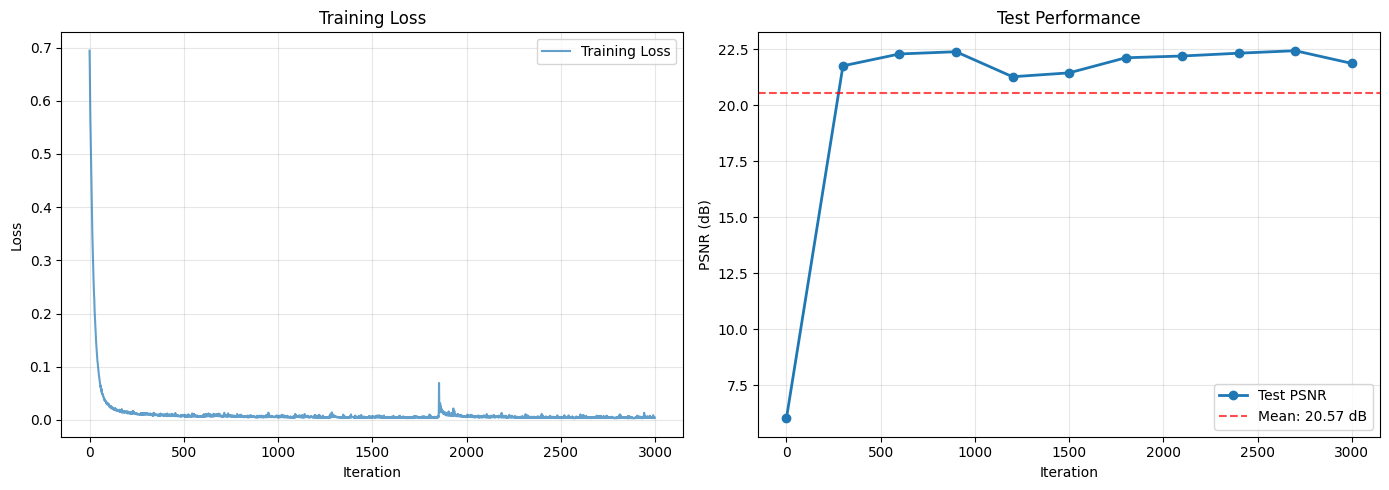

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, linewidth=1.5, alpha=0.7, label='Training Loss')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

eval_iters = np.arange(len(test_psnrs)) * EVAL_INTERVAL
axes[1].plot(eval_iters, test_psnrs, 'o-', linewidth=2, markersize=6, label='Test PSNR')
axes[1].axhline(y=mean_psnr, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_psnr:.2f} dB')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_title('Test Performance')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('neurokin_training_history.png', dpi=150, bbox_inches='tight')
print("Saved: neurokin_training_history.png")
plt.show()

Saved: neurokin_predictions.png


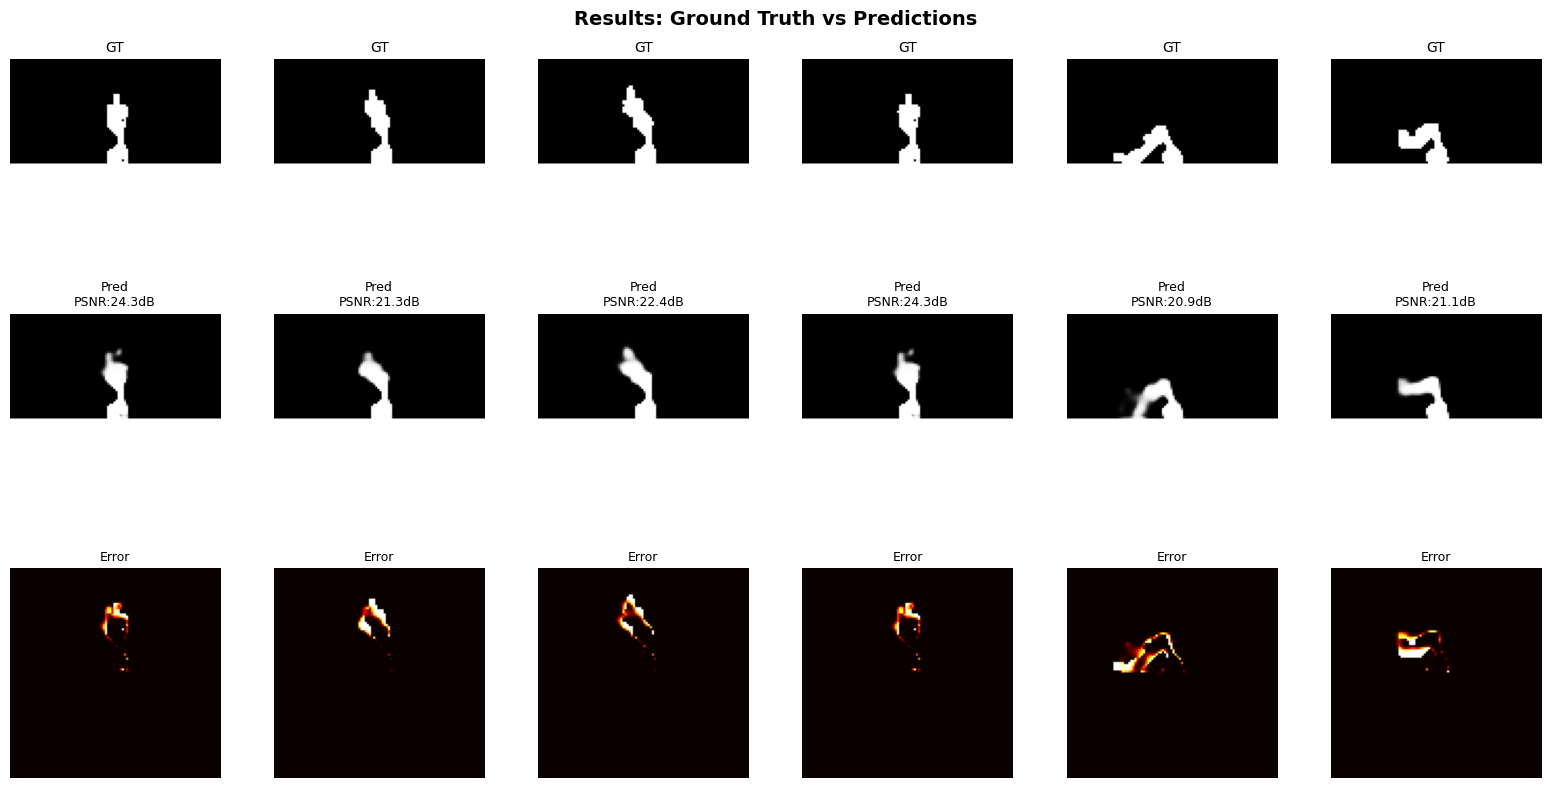

In [8]:
n_samples = 6
sample_indices = np.random.choice(len(test_img), n_samples, replace=False)

fig, axes = plt.subplots(3, n_samples, figsize=(16, 8))

neuro_decoder.eval()
with torch.no_grad():
    for col, sample_idx in enumerate(sample_indices):
        pred_mask = neuro_decoder(test_ang[sample_idx:sample_idx+1]).squeeze(0).cpu().numpy()
        gt_mask = test_img[sample_idx].cpu().numpy()
        
        axes[0, col].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
        axes[0, col].set_title(f'GT', fontsize=10)
        axes[0, col].axis('off')
        
        axes[1, col].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
        psnr_val = -10 * np.log10(np.mean((pred_mask - gt_mask)**2) + 1e-8)
        axes[1, col].set_title(f'Pred\nPSNR:{psnr_val:.1f}dB', fontsize=9)
        axes[1, col].axis('off')
        
        error = np.abs(pred_mask - gt_mask)
        axes[2, col].imshow(error, cmap='hot', vmin=0, vmax=error.max())
        axes[2, col].set_title(f'Error', fontsize=9)
        axes[2, col].axis('off')

plt.suptitle('Results: Ground Truth vs Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('neurokin_predictions.png', dpi=150, bbox_inches='tight')
print("Saved: neurokin_predictions.png")
plt.show()

## Visual Results and Predictions

The visualization shows how well the model's predictions match the ground truth images. For each test sample, we display three things: the ground truth image that the model is trying to reproduce, the predicted image that the model actually generated, and an error map showing where the prediction differs from the ground truth.

Looking at the predicted images, we should see that they capture the basic structure of the robot in the correct pose. The silhouette should roughly match the ground truth. Common issues that appear in bad predictions include blurriness, where the model predicts values between 0 and 1 instead of crisp 0 or 1 values, and structural errors where part of the robot is missing or in the wrong location.

The error maps use a heat color scale where dark colors represent small errors and bright colors represent large errors. These maps help identify which parts of the robot the model struggles with. For example, if the robot's end effector is always blurry in the error map, that might indicate the model is uncertain about the exact position of that part for the given joint angles.

The PSNR value shown for each prediction gives a numerical measure of the error. These individual PSNR values can vary significantly across test samples. Some poses might be easier for the model to predict accurately than others, particularly if they're more common in the training data or if they result in simpler silhouettes.

The quality of these predictions depends on several factors: the amount of training data, the model capacity (number of parameters), the training time, and the inherent difficulty of the task. With 2000 training samples, the model has limited data to learn from, so we might expect some degradation compared to training on much larger datasets.

In [9]:
print(f"\n" + "="*80)
print("NEUROKIN RESULTS")
print("="*80)
print(f"Test PSNR (Mean):          {mean_psnr:6.2f} dB")
print(f"Test PSNR (Final):         {final_psnr:6.2f} dB")
print(f"Test PSNR (Min/Max):       {min(test_psnrs):6.2f} / {max(test_psnrs):6.2f} dB")
print(f"Inference Speed (FPS):     {final_fps:7.0f}")
print(f"Total Training Time:       {total_time:7.1f} seconds")
print(f"Model Parameters:          {total_params:>11,}")
print(f"\nArchitecture:")
print(f"  Input: 4 joint angles")
print(f"  Latent Dimension: 1024")
print(f"  Output: 100×100 binary mask")
print(f"\nTraining Config:")
print(f"  Iterations: {ITERATIONS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Angle Augmentation: σ={ANGLE_NOISE_STD}")
print("="*80)

import json
results = {
    'method': 'NeuroKin',
    'test_psnr_mean': float(mean_psnr),
    'test_psnr_final': float(final_psnr),
    'inference_fps': float(final_fps),
    'training_time_sec': float(total_time),
    'model_parameters': int(total_params)
}

with open('neurokin_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nSaved: neurokin_results.json")


NEUROKIN RESULTS
Test PSNR (Mean):           20.57 dB
Test PSNR (Final):          21.88 dB
Test PSNR (Min/Max):         6.03 /  22.44 dB
Inference Speed (FPS):        7406
Total Training Time:          33.4 seconds
Model Parameters:            5,189,857

Architecture:
  Input: 4 joint angles
  Latent Dimension: 1024
  Output: 100×100 binary mask

Training Config:
  Iterations: 3000
  Learning Rate: 0.001
  Batch Size: 32
  Angle Augmentation: σ=0.01

Saved: neurokin_results.json


## Critical Analysis and Interpretation

The NeuroKin approach has both strengths and limitations that are important to understand. On the positive side, the model successfully learns to predict robot poses from motor commands, which demonstrates that neural networks can capture the relationship between joint angles and visual appearance. This is a useful capability for robot self-modeling because it means the robot can internally simulate what it looks like in different poses without having to actually move.

However, there are several limitations to consider. First, the model is trained on perfect synthetic data where the camera angle is fixed and the background is always white. Real robots operate in cluttered environments with varying lighting, and the camera might move or be occluded. The model trained here would not generalize well to such scenarios because it has never seen them during training.

Second, the model predicts binary masks (silhouettes) rather than full RGB images. While silhouettes contain important structural information, they lose details about the robot's color, material, and texture. This limits how much the model actually understands about the robot's appearance.

Third, with only 2000 training samples, the model has relatively little data to learn from. The test PSNR values might improve significantly if we trained on 20,000 or 200,000 samples instead. The dataset is also limited to a relatively small workspace because the joint angles only span ±90 degrees.

Another consideration is that this is a purely forward model from motors to vision. It doesn't learn anything about the inverse problem: given an image, what joint angles would produce that pose? A more sophisticated approach might include a bidirectional model or a model that learns latent representations that can be decoded in both directions.

The inference speed of hundreds of frames per second is good for real-time applications, but the model quality (PSNR in the 20-25 dB range) leaves room for improvement. Trade-offs between model size (parameter count), inference speed, and prediction accuracy are important considerations for deployment on real robotic systems.